# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Основные шаги:

1. Загрузить данные, путь к файлу: /datasets/autos.csv.

2. Изучить данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.

3. Подготовить выборки для обучения моделей.

4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

5. Проанализировать время обучения, время предсказания и качество моделей.

6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

### Примечания:

- Для оценки качества моделей применяйте метрику RMSE.

- Значение метрики RMSE должно быть меньше 2500.

- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.

- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.

- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.

### Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Из них мы оставляем: тип кузова, дата регистрации автомобиля (для информативности объединим год и месяц регистрации автомобиля), тип коробки передач, мощность, модель авто, пробег, тип топлива, марку авто, а также была машина в ремонте или нет. Также, для информативности можно оставить количество фотографий, но эти данные не требуются для обучения модели. Все остальные данные незначительно влияют или не влияют на рыночную стоимость автомобиля.

### Целевой признак

- Price — цена (евро)

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (mean_absolute_error, make_scorer, precision_score, recall_score, f1_score)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.dummy import DummyRegressor

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

from time import time
import os
RANDOM_STATE = np.random.randint(12345)

In [42]:
pth1 = '/datasets/autos.csv'
pth2 = 'C:/Users/Солнышко/Documents/autos.csv'
pth3 = 'C:/Users/Home/Documents/Яндекс/Сатанист/autos.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
elif os.path.exists(pth3):
    data = pd.read_csv(pth3)
else:
    print('Something is wrong')
    
# сбор данных о датафрейме:
def data_info(data):
    print(f'''
    ----------------------------------------
    Первые строки датафрейма:
    ----------------------------------------''')
    display(data.head())
    print(f'''
    ----------------------------------------
    Последние строки датафрейма:
    ----------------------------------------''')
    display(data.tail())
    print(f'''
    ----------------------------------------
    Общая информация:
    ----------------------------------------''')
    print(data.info())
    print(f'''
    ----------------------------------------
    Дупликаты:
    ----------------------------------------''')
    print(data.duplicated().sum())
    print(f'''
    ----------------------------------------
    Пропуски:
    ----------------------------------------''')
    display(round(data.isna().sum(),))

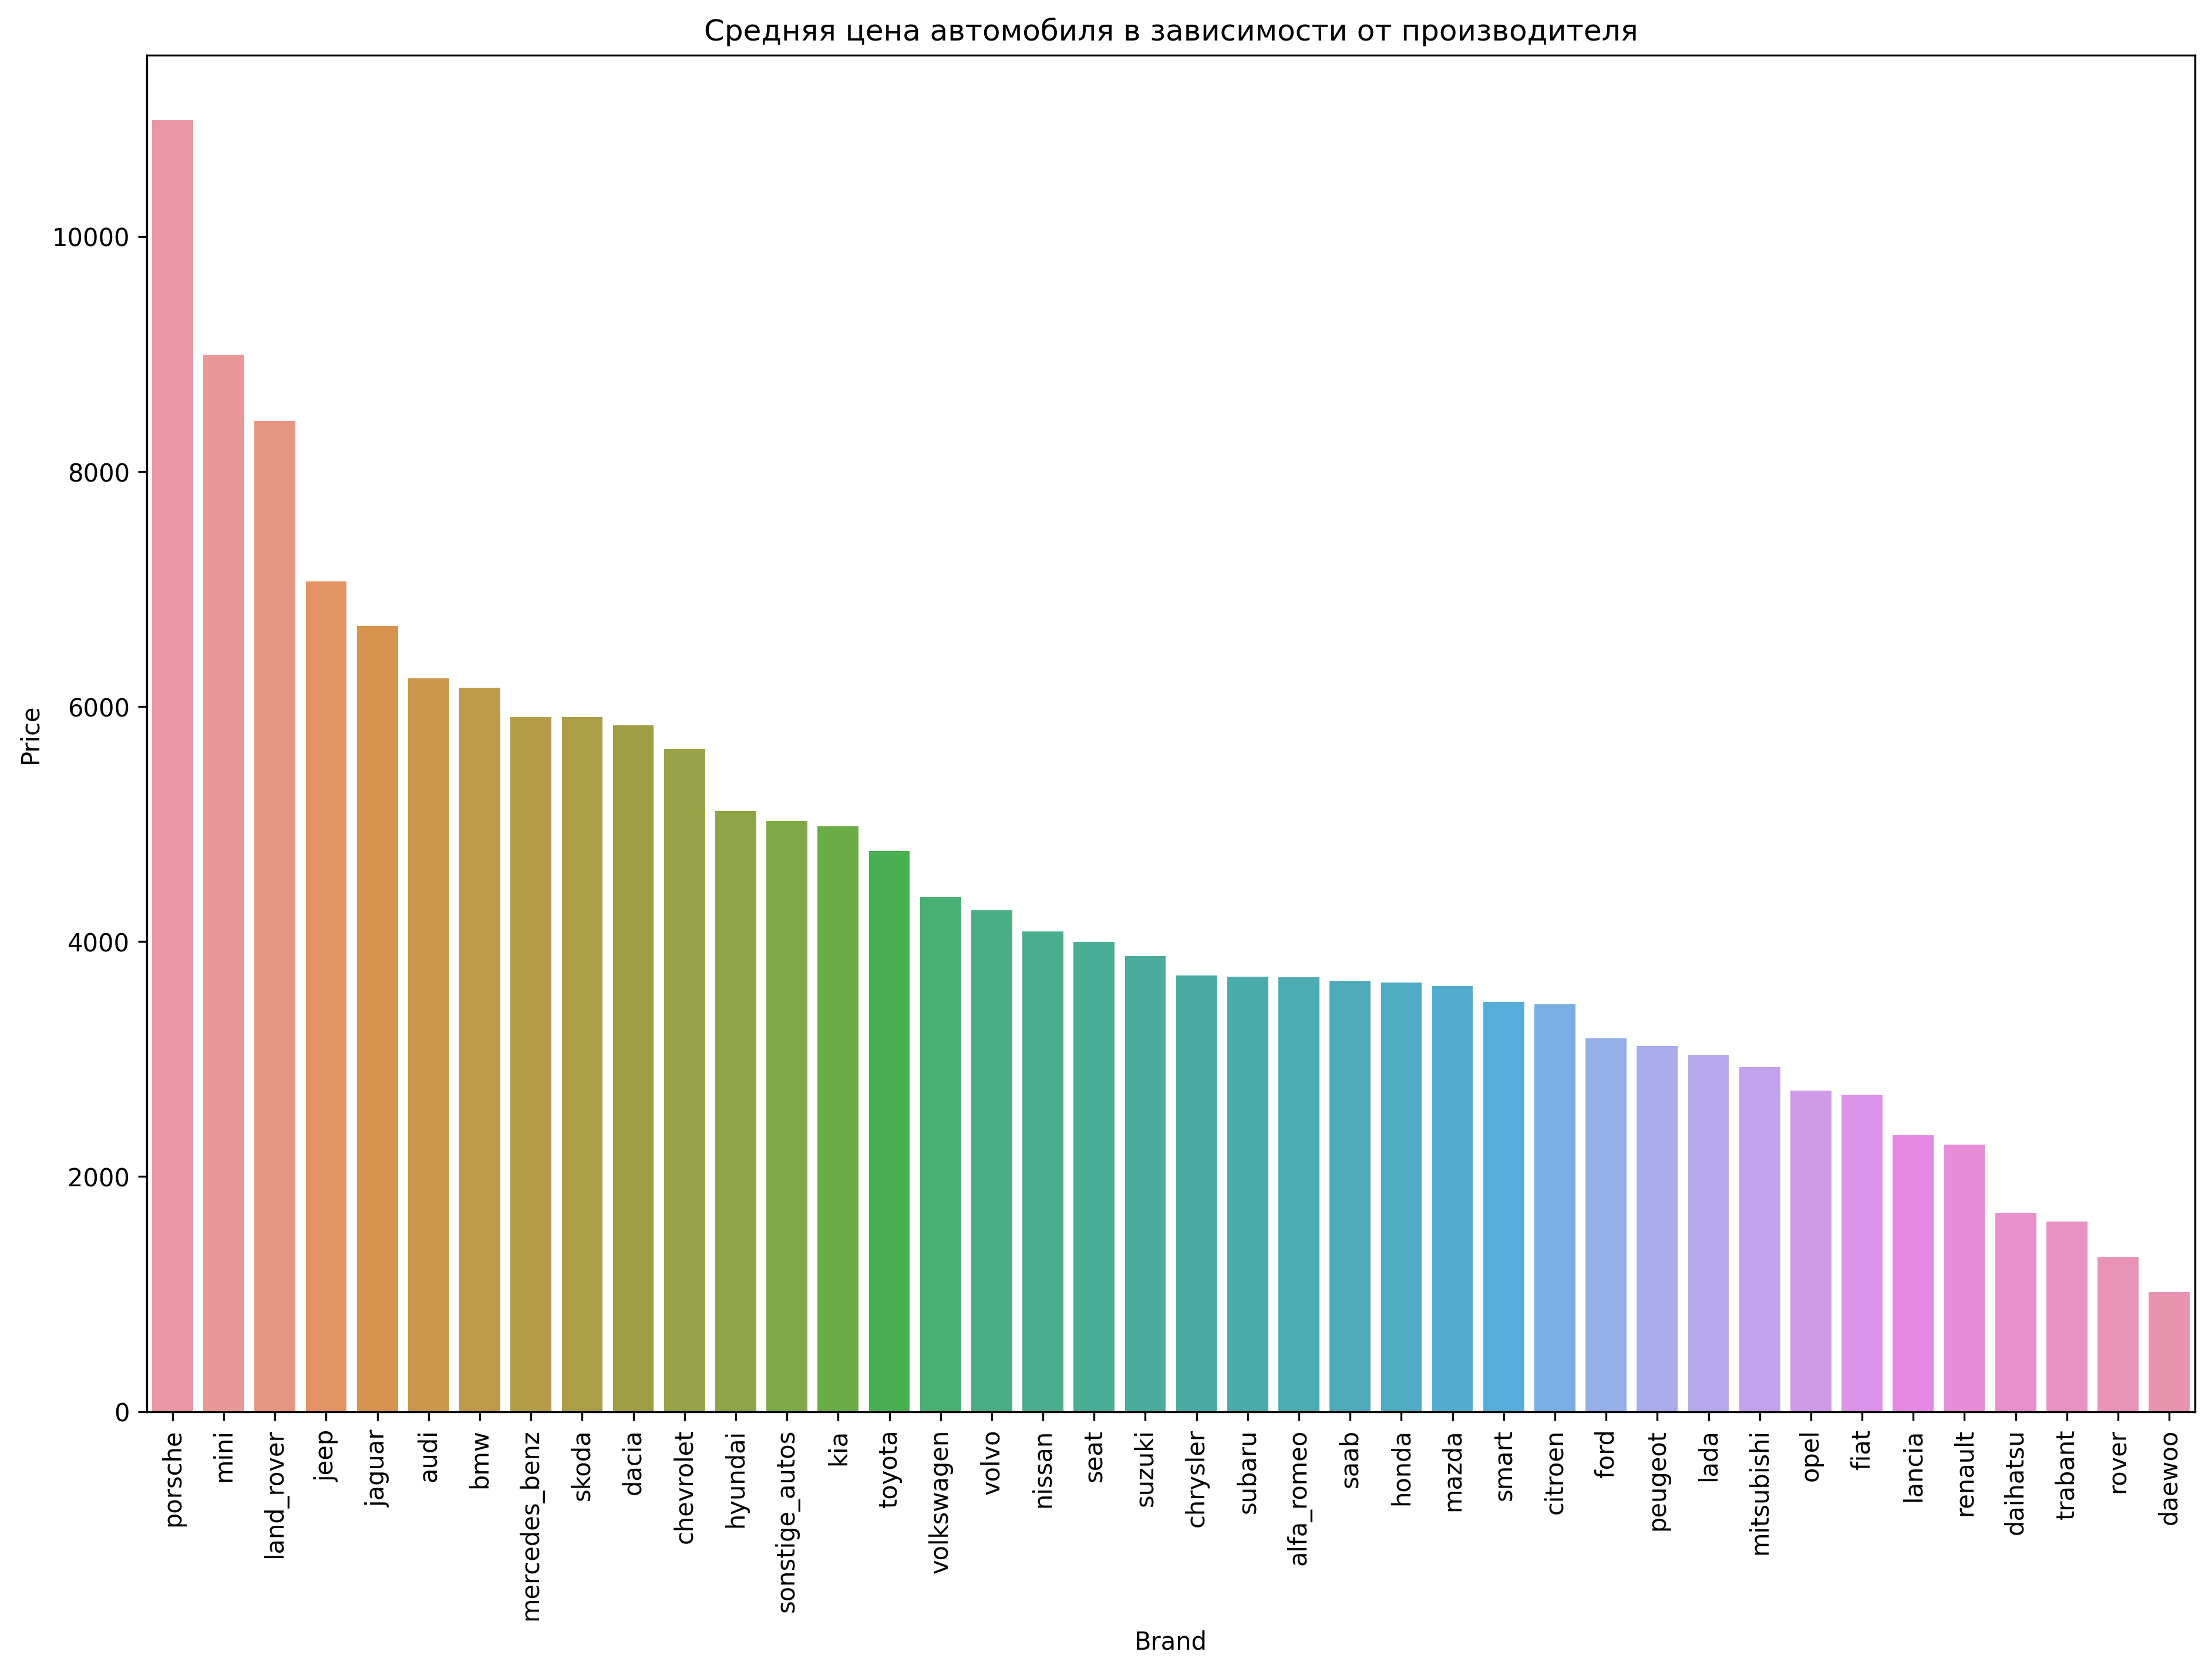

In [43]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 300
a = pd.pivot_table(data, index='Brand', values='Price', aggfunc='mean').reset_index().sort_values('Price',ascending=False)
sns.barplot(data=a, x='Brand', y='Price')
plt.xticks(rotation=90)
plt.title('Средняя цена автомобиля в зависимости от производителя')
plt.show()

In [44]:
data_info(data)


    ----------------------------------------
    Первые строки датафрейма:
    ----------------------------------------


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



    ----------------------------------------
    Последние строки датафрейма:
    ----------------------------------------


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21



    ----------------------------------------
    Общая информация:
    ----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  Pos

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

## Подготовка данных

Мы видим, что в данных достаточно много пропусков и аномалий - как минимум в колонке года минимальный год - 1000 - вызывает подозрения. Там где в колоке *Price* стоит *0* - данные неинформативны, так как целевого признака там нет - их можно удалить. Также удалить дупликаты. После удаления ненужных столбцов и строк - можно будет провести более тщательный анализ данных.

Примерный план:

1. Переименовать колонки
2. Убрать дупликаты, убрать пропуски по Price, удалить ненужные столбцы, чекнуть год производства - если дата разумна - оставить в datetime, если нет - удалить, чекнуть километраж.
3. Построить boxplot на весь оставшийся data и написать описание - чекнуть все что можно на аномалии - их в data много.


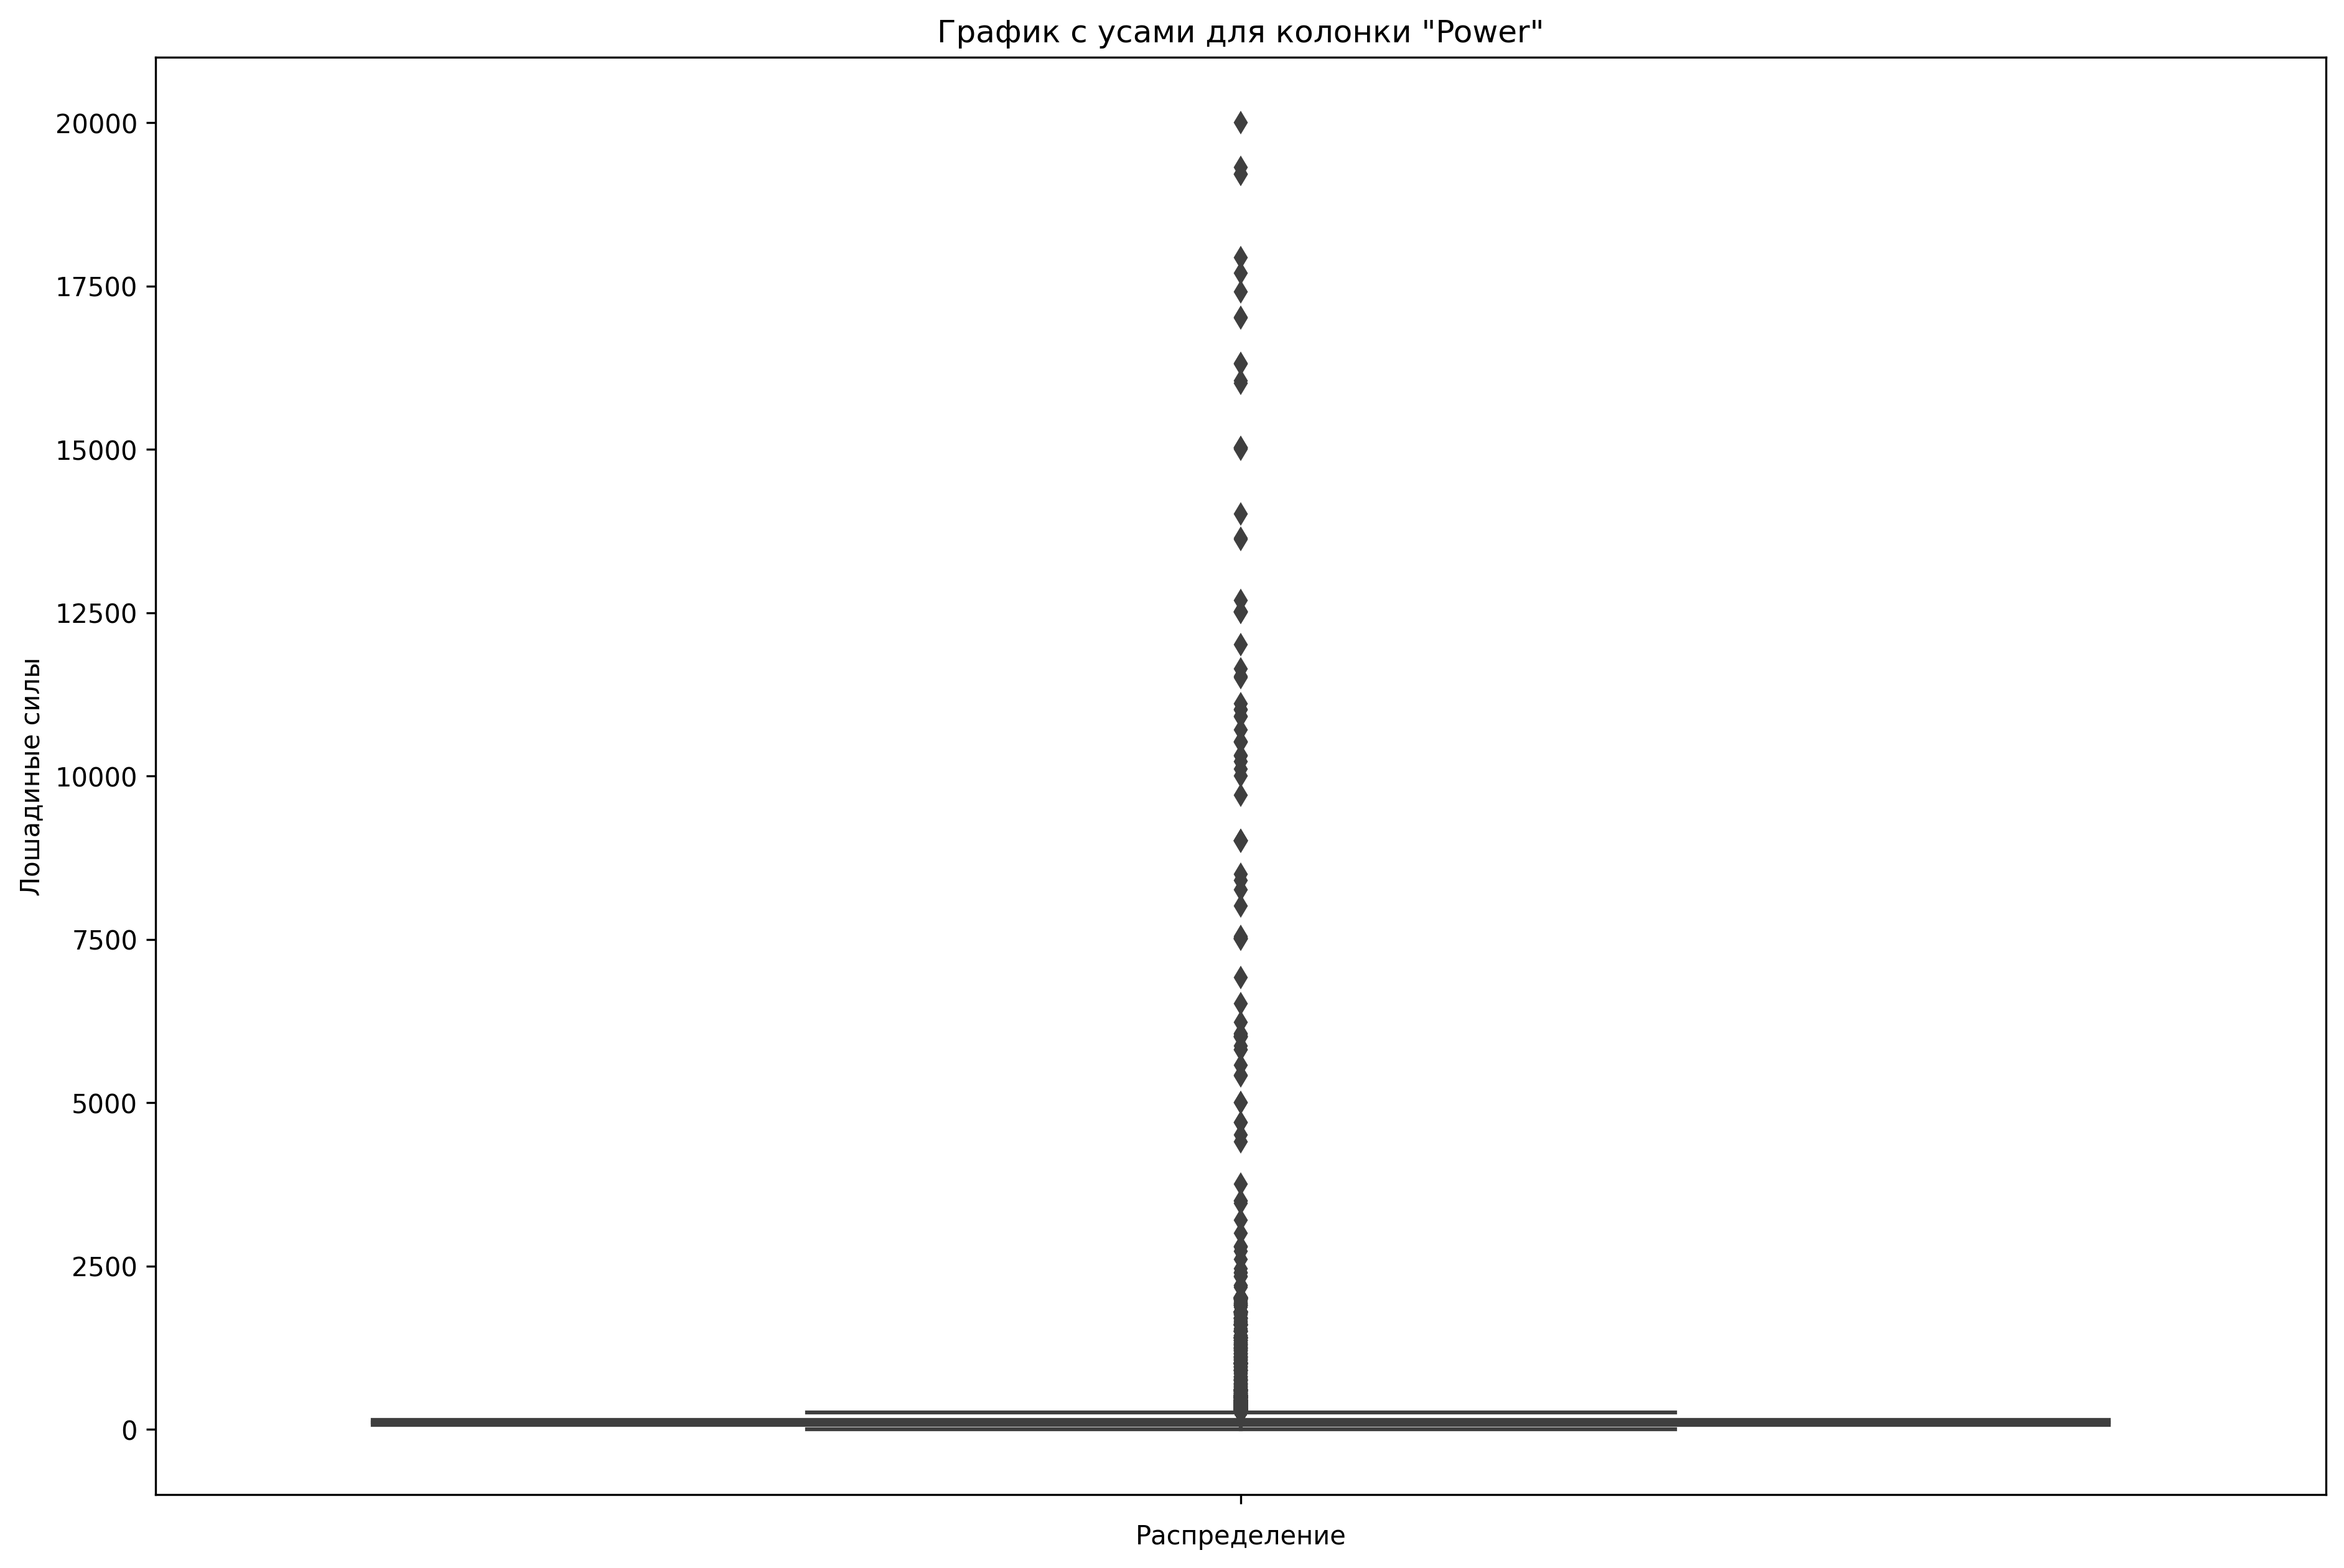

In [45]:
fig, ax = plt.subplots()
sns.boxplot(y=data['Power'])
plt.title('График с усами для колонки "Power"')
plt.xlabel('Распределение')
plt.ylabel('Лошадиные силы')
plt.show()

По данным на 16.09.2023 - максимальное количество лошадиных сил, которые может воспроизвести автомобиль - 4515 л.с. Следовательно, все остальное **точно** выбросы. Также сильно сомневаюсь, что в датасете есть редкие машины самого начала автомобилестроения, с 0 лошадиных сил, но очень высокой стоимостью, обусловленной их редкостью, так что это тоже можно исключить. Остальные данные посмотрим после первичной обработки.

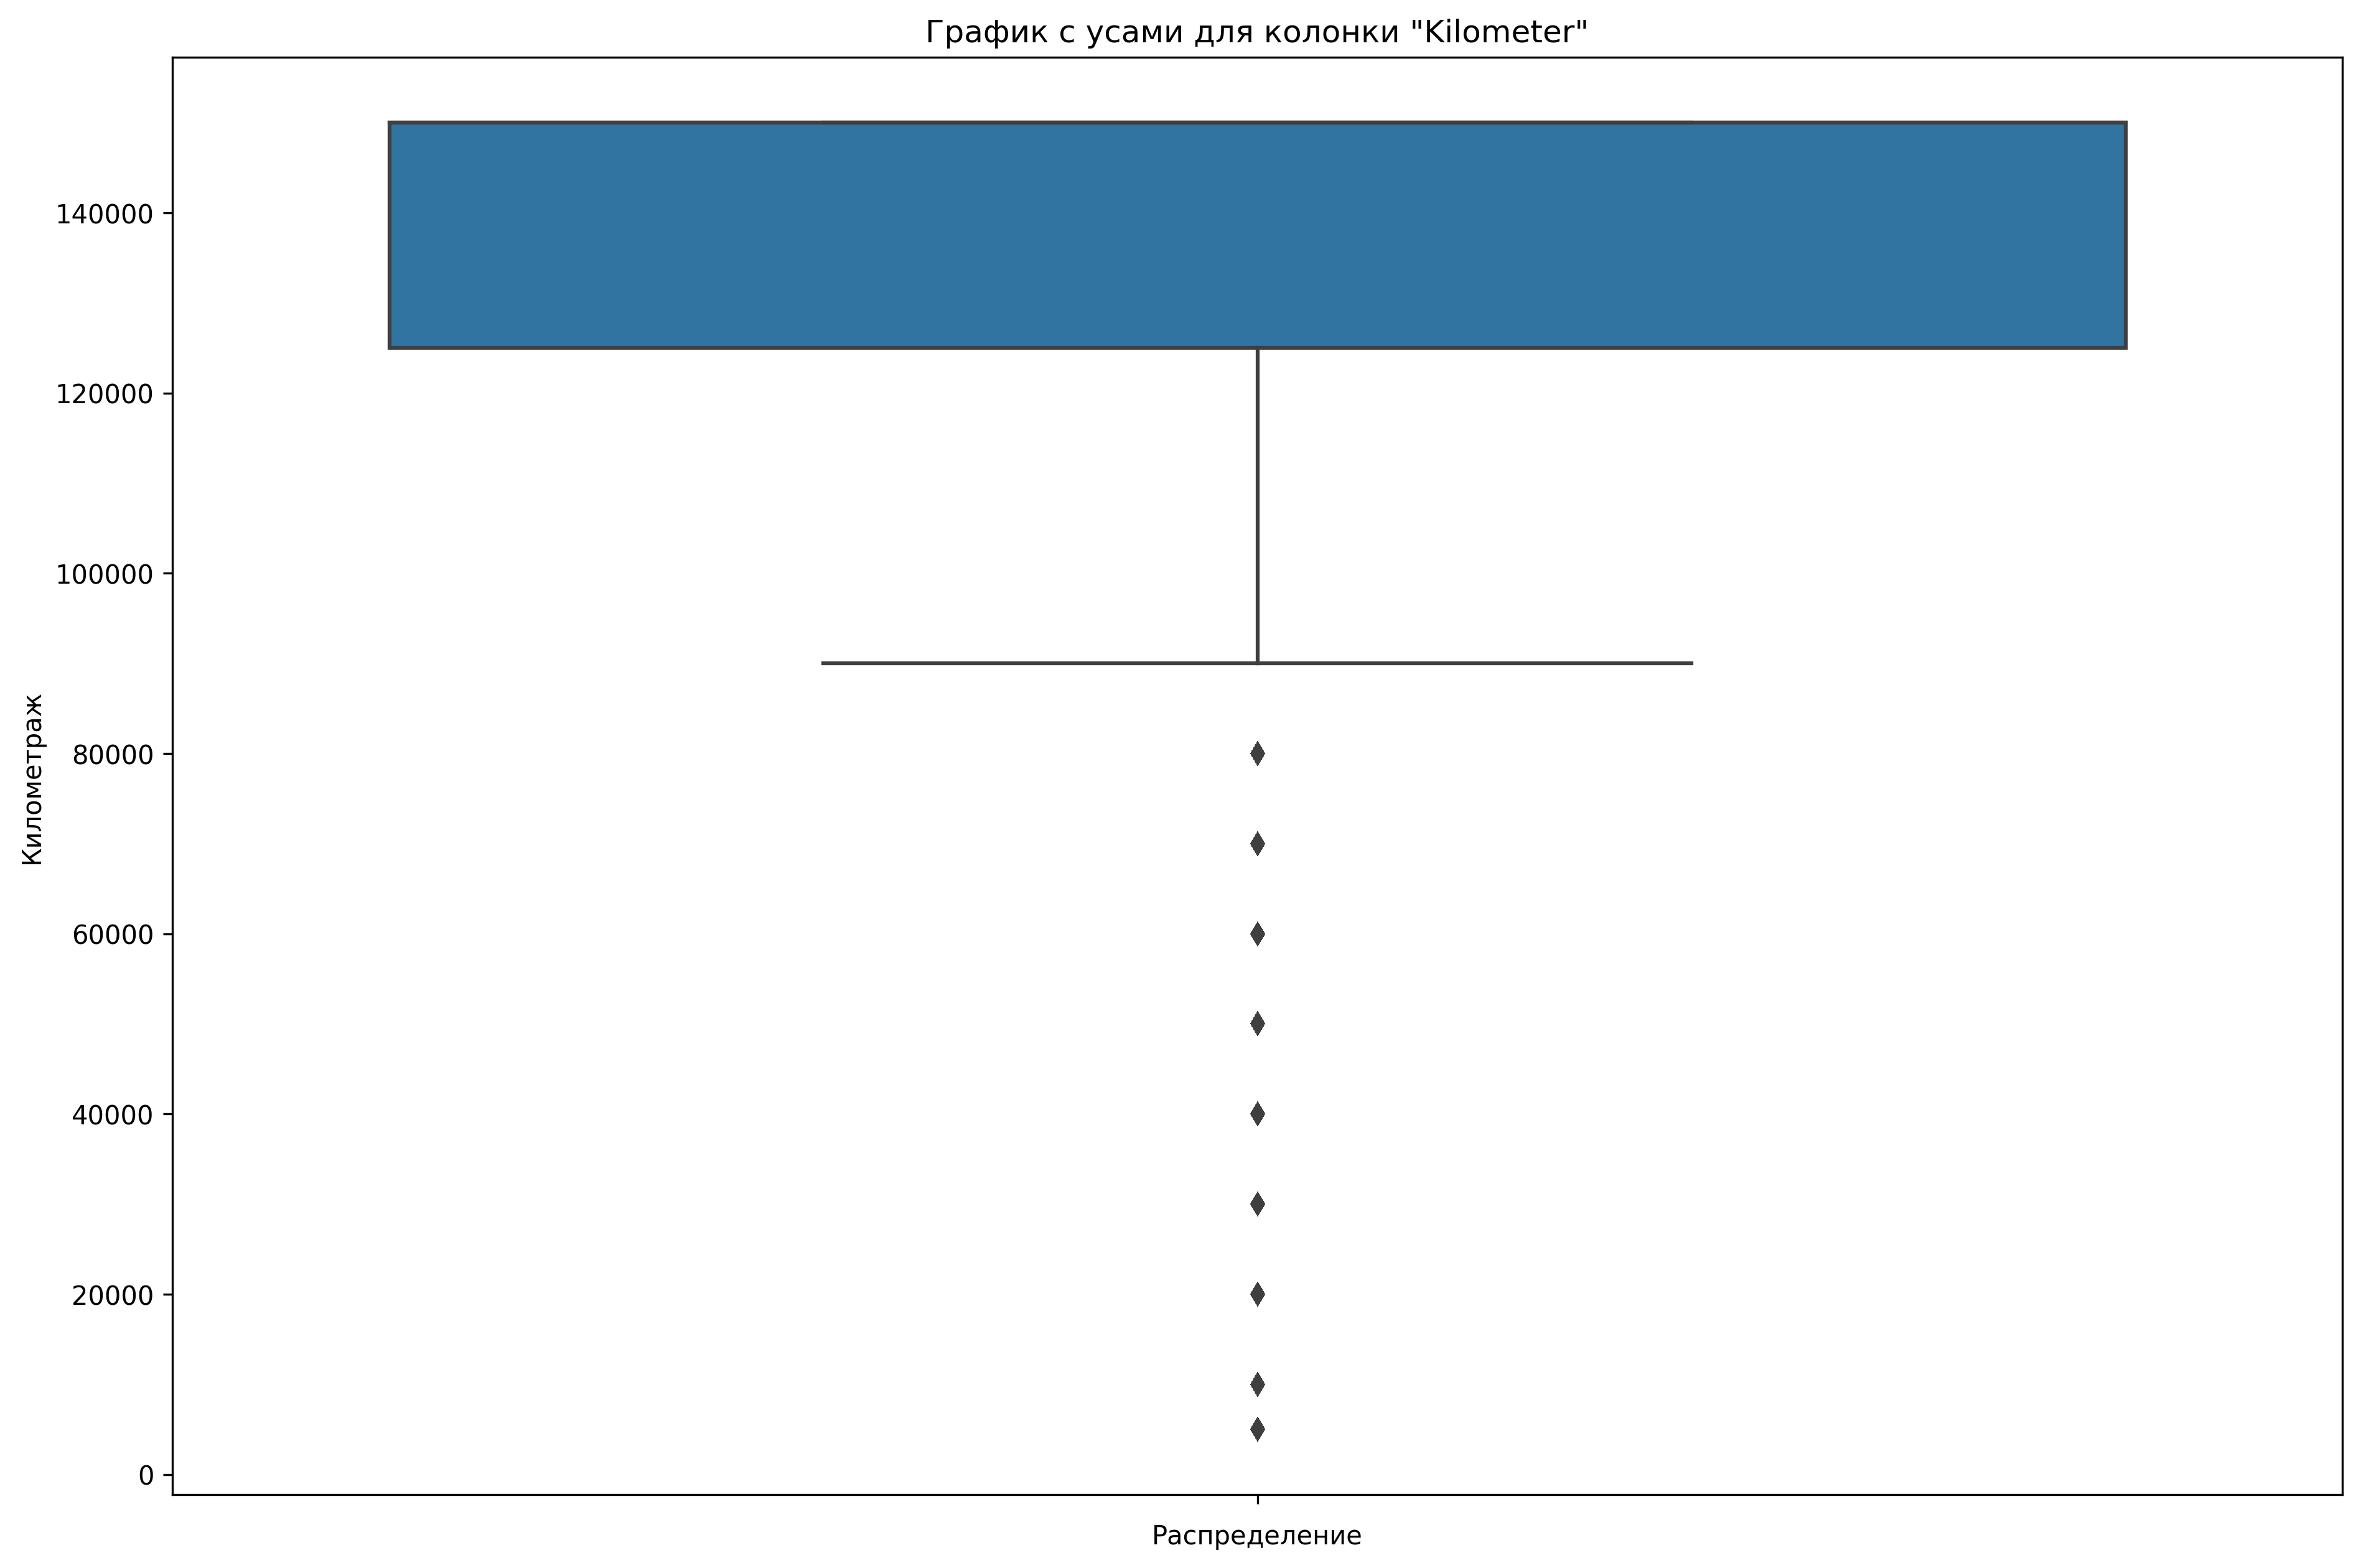

In [46]:
fig, ax = plt.subplots()
sns.boxplot(y=data['Kilometer'])
plt.title('График с усами для колонки "Kilometer"')
plt.xlabel('Распределение')
plt.ylabel('Километраж')
plt.show()

Километраж в 5000 километров для б/у машины 2010-х годов - странная вещь. Удалим все, что около нуля - эти данные не информативны. Также посмотрим дату выгрузки:

In [47]:
pd.to_datetime(data['DateCrawled']).dt.year.unique()

array([2016])

Ограничение по году сразу поставим 2016.

In [48]:
pd.to_datetime(data['DateCrawled']).dt.month.unique()

array([3, 4])

У нас также есть 0 месяц - не известно, что послужило такому, но так как данные - ценный ресурс, заменим эти значения медианой

In [49]:
df = data[['Price','VehicleType','RegistrationYear','RegistrationMonth','Gearbox','Power',
           'Model','Kilometer','FuelType','Brand','Repaired','DateCrawled']]
df.columns = ['price','type','registration_year','registration_month','gearbox','power',
              'model','kilometer','fuel','brand','repair','month_cr']
# из столбца "DateCrawled" нам нужен только месяц
df['month_cr'] = pd.to_datetime(df['month_cr']).dt.month
df = df.query('price > 49 and power < 4515 and kilometer > 0 and power > 0 and \
1886 < registration_year < 2017 and registration_month <= month_cr').drop_duplicates() 
df

,price,type,registration_year,registration_month,gearbox,power,model,kilometer,fuel,brand,repair,month_cr
9,999,small,1998,0,manual,101,golf,150000,NaN,volkswagen,NaN,3
13,2500,wagon,2004,2,manual,131,passat,150000,NaN,volkswagen,no,3
14,17999,suv,2011,3,manual,190,navara,70000,gasoline,nissan,no,3
16,300,NaN,2016,0,NaN,60,polo,150000,petrol,volkswagen,NaN,4
17,1750,small,2004,2,auto,75,twingo,150000,petrol,renault,no,3
...,...,...,...,...,...,...,...,...,...,...,...,...
354344,1600,wagon,1998,2,manual,125,a4,150000,petrol,audi,no,4
354350,1400,sedan,2001,2,manual,125,astra,150000,petrol,opel,no,4
354356,999,convertible,2000,4,manual,95,megane,150000,petrol,renault,NaN,4
354366,1199,convertible,2000,3,auto,101,fortwo,125000,petrol,smart,no,3


После обработки удалим признаки, которые нам не нужны:

In [50]:
df = df[['price','type','registration_year','gearbox','power','model','kilometer','fuel','brand','repair']]

In [51]:
data_info(df)


    ----------------------------------------
    Первые строки датафрейма:
    ----------------------------------------


,price,type,registration_year,gearbox,power,model,kilometer,fuel,brand,repair
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
13,2500,wagon,2004,manual,131,passat,150000,NaN,volkswagen,no
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
17,1750,small,2004,auto,75,twingo,150000,petrol,renault,no



    ----------------------------------------
    Последние строки датафрейма:
    ----------------------------------------


,price,type,registration_year,gearbox,power,model,kilometer,fuel,brand,repair
354344,1600,wagon,1998,manual,125,a4,150000,petrol,audi,no
354350,1400,sedan,2001,manual,125,astra,150000,petrol,opel,no
354356,999,convertible,2000,manual,95,megane,150000,petrol,renault,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no



    ----------------------------------------
    Общая информация:
    ----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 86243 entries, 9 to 354367
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   price              86243 non-null  int64 
 1   type               81249 non-null  object
 2   registration_year  86243 non-null  int64 
 3   gearbox            83760 non-null  object
 4   power              86243 non-null  int64 
 5   model              81914 non-null  object
 6   kilometer          86243 non-null  int64 
 7   fuel               79221 non-null  object
 8   brand              86243 non-null  object
 9   repair             69636 non-null  object
dtypes: int64(4), object(6)
memory usage: 7.2+ MB
None

    ----------------------------------------
    Дупликаты:
    ----------------------------------------
2308

    ----------------------------------------
    Пр

price                    0
type                  4994
registration_year        0
gearbox               2483
power                    0
model                 4329
kilometer                0
fuel                  7022
brand                    0
repair               16607
dtype: int64

До 1950-х годов - преимущественно использовались механические коробки передач, поэтому их и поставим в пропуски:

In [52]:
df.loc[(df['gearbox'].isna()) & (df['registration_year'] < 1950),'gearbox']='manual'

Модель - один из ключевых ценообразующих факторов. Пропуски в этой колонке достаточно критичны и малы, чтобы удалить их.

In [53]:
(df['model'].isna().sum()/df.shape[0])*100

5.019537817562005

In [54]:
df= df[df['model'].notna()]

In [55]:
df.isna().sum()

price                    0
type                  4217
registration_year        0
gearbox               2061
power                    0
model                    0
kilometer                0
fuel                  5751
brand                    0
repair               14842
dtype: int64

Все оставшиеся пропуски предлагаю заполнить общим значением "не известно"

In [56]:
filling = 'not known'
columns = ['type','gearbox','fuel','repair']
for i in columns:
    df[i] = df[i].fillna(filling)

Разделим на выборки:

In [146]:
features = df.drop('price', axis=1)
target = df['price']

# выделим сразу тестовую выборку
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, random_state=RANDOM_STATE)

Оценивать модели мы будем по следующему алгоритму:
- RMSE получаем с кросс-валидации
- время обучения и предсказания - замеряем на `train` выборке


*Промежуточный итог:*

- изучили данные, нашли много аномалий, выбросов, пропусков и несколько дупликатов
- "подчистили" данные - избавились от неинформативных составляющих
- заполнили пропуски
- разделили на 2 выборки: тренировочную и тестовую

## Обучение моделей

Хотелось бы рассмотреть 4 модели: 

- Random Forest
- LightGBM
- CatBoost
- LinearRegression

Подготовим функцию для поиска по сетке:

In [178]:
def rmse(target, predicted):
    rmse = mean_squared_error(target, predicted)**0.5
    return rmse

def return_best_model(model, params, features_train, target_train, linear_model=False):
    cat_col = features_train.select_dtypes(include='object').columns.to_list()
    num_col = features_train.select_dtypes(exclude='object').columns.to_list()    
    num_pipeline = Pipeline(steps=[('scale', StandardScaler())])
    
    if linear_model is not False:
        cat_pipeline = Pipeline(steps=[('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))])
        
    else:
        cat_pipeline = Pipeline(steps=[('one-hot', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
        
    col_trans = ColumnTransformer(transformers=[('num_pipeline', num_pipeline, num_col),
                                                ('cat_pipeline', cat_pipeline, cat_col)], remainder='drop', n_jobs=-1)
    model_pipeline = Pipeline(steps=[('preprocess',col_trans), ('reg', model)])
    
    score = make_scorer(rmse, greater_is_better = False)
    
    search = RandomizedSearchCV(model_pipeline, param_distributions = params, cv=5, 
                                    scoring = score, n_iter=5, random_state=RANDOM_STATE)
    search.fit(features_train, target_train)
    return search

In [198]:
model = LinearRegression()
params_linreg = {}
model_linreg = return_best_model(model, params_linreg, features_train, target_train, True)
print(f'''best params: {model_linreg.best_params_}
best score: {-model_linreg.best_score_}''')

best params: {}
best score: 2668.581937790749


In [161]:
model = RandomForestRegressor(random_state=RANDOM_STATE)
params_rfr = {
    'reg__n_estimators':[2, 5, 10, 20],
    'reg__max_features': ['sqrt', None],
    'reg__max_leaf_nodes':[2, 5, 10, 20],
    'reg__min_samples_split': [2, 3, 4],
    'reg__min_samples_leaf': [1, 2, 3, 4],
    'reg__max_depth': [1, 5, 10, 20]}

model_rfr = return_best_model(model_rfr, params_rfr, features_train, target_train, False)
print(f'''best params: {model_rfr.best_params_}
best score: {-model_rfr.best_score_}''')

best params: {'reg__n_estimators': 2, 'reg__min_samples_split': 2, 'reg__min_samples_leaf': 3, 'reg__max_leaf_nodes': 20, 'reg__max_features': None, 'reg__max_depth': 5}
best score: 2392.775823356546


In [160]:
model_lgbm = LGBMRegressor(verbose=-1)
params_lgbm = {'reg__boosting_type':['gbdt','dart','rf'], 
               'reg__max_depth':[10, 50, 100],
               'reg__class_weight':['balanced', None]}

model_lgbm = return_best_model(model_lgbm, params_lgbm, features_train, target_train, False)
print(f'''best params: {model_lgbm.best_params_}
best score: {-model_lgbm.best_score_}''')

best params: {'reg__max_depth': 50, 'reg__class_weight': None, 'reg__boosting_type': 'gbdt'}
best score: 1610.590863139499


In [162]:
model_cb = CatBoostRegressor(verbose=1000, loss_function='RMSE')
params_cb = {'reg__learning_rate':[0.03, 0.05],
             'reg__n_estimators': [10,50,100,500]}
model_cb = return_best_model(model_cb, params_cb, features_train, target_train, False)
print(f'''best params: {model_cb.best_params_}
best score: {-model_cb.best_score_}''')

0:	learn: 4373.4159110	total: 178ms	remaining: 1.6s
9:	learn: 3360.2241196	total: 314ms	remaining: 0us
0:	learn: 4373.5671885	total: 14.8ms	remaining: 133ms
9:	learn: 3365.6999276	total: 145ms	remaining: 0us
0:	learn: 4369.6789500	total: 15.2ms	remaining: 137ms
9:	learn: 3358.7505515	total: 144ms	remaining: 0us
0:	learn: 4380.2251058	total: 10.7ms	remaining: 96.4ms
9:	learn: 3365.5461218	total: 124ms	remaining: 0us
0:	learn: 4388.1423219	total: 14.6ms	remaining: 131ms
9:	learn: 3373.0315837	total: 141ms	remaining: 0us
0:	learn: 4373.4159110	total: 15.8ms	remaining: 775ms
49:	learn: 2080.1641252	total: 663ms	remaining: 0us
0:	learn: 4373.5671885	total: 11.5ms	remaining: 565ms
49:	learn: 2079.2408389	total: 641ms	remaining: 0us
0:	learn: 4369.6789500	total: 15.2ms	remaining: 745ms
49:	learn: 2069.9679804	total: 668ms	remaining: 0us
0:	learn: 4380.2251058	total: 15.3ms	remaining: 751ms
49:	learn: 2064.0201902	total: 651ms	remaining: 0us
0:	learn: 4388.1423219	total: 15.3ms	remaining: 748m

Мы получили необходимые нам гиперпараметры. Осталось только обучить и проверить точность и скорость работы разных моделей.

Предварительно, лучше всех справляется LightGBM - у него самая высокая точность при высокой скорости, после нее хорошо себя показала CatBoost. RandomForestRegressor занимает больше всего времени, LinReg - наименее точна.

Создадим результирующую таблицу:

In [217]:
res = pd.DataFrame(index=range(0,4), columns = ['model','params','best_rmse','train_time','prediction_time'])
res

,model,params,best_rmse,train_time,prediction_time
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN


Второй критерий выбора модели по задаче заказчика - скорость обучения и скорость предсказания:

In [187]:
def models_predict(model, features_train, target_train):  
    start_fit = time()
    model = model.fit(features_train, target_train)
    end_fit = time()
    
    fit_time = (end_fit-start_fit)/60
    
    start_pred = time()
    predictions = model.predict(features_train)
    end_pred = time()
    
    pred_time = (end_pred-start_pred)/60
    
    return fit_time, pred_time

In [218]:
model = model_linreg.best_estimator_
fit_time, pred_time = models_predict(model, features, target)

res.loc[0] = ['linreg', model_linreg.best_params_, -model_linreg.best_score_, fit_time, pred_time]

print(f'''Fit time: {fit_time} min;
Prediction time: {pred_time} min''')

Fit time: 0.0742055853207906 min;
Prediction time: 0.03186236222585042 min


In [219]:
model = model_rfr.best_estimator_
fit_time, pred_time = models_predict(model, features, target)

res.loc[1] = ['randomforest', model_rfr.best_params_, -model_rfr.best_score_, fit_time, pred_time]

print(f'''Fit time: {fit_time} min;
Prediction time: {pred_time} min''')

Fit time: 0.014503029982248943 min;
Prediction time: 0.008297836780548096 min


In [220]:
model = model_lgbm.best_estimator_
fit_time, pred_time = models_predict(model, features, target)

res.loc[2] = ['lightgbm', model_lgbm.best_params_, -model_lgbm.best_score_, fit_time, pred_time]

print(f'''Fit time: {fit_time} min;
Prediction time: {pred_time} min''')

Fit time: 0.023434996604919434 min;
Prediction time: 0.014615456263224283 min


In [221]:
model = model_cb.best_estimator_
fit_time, pred_time = models_predict(model, features, target)

res.loc[3] = ['catboost', model_cb.best_params_, -model_cb.best_score_, fit_time, pred_time]

print(f'''Fit time: {fit_time} min;
Prediction time: {pred_time} min''')

0:	learn: 4434.1686685	total: 18.5ms	remaining: 9.24s
499:	learn: 1623.0053980	total: 8.55s	remaining: 0us
Fit time: 0.16801746288935343 min;
Prediction time: 0.01734269062678019 min


RandomForest работает быстрее всех, однако у него относительно высокая ошибка. 

В условиях данной задачи интересна наиболее высокая точность, при *сравнительно небольшой скорости*.
Оптимальный вариант - **LightGBM**. У этой модели самая высокая скорость обучения, сопоставимая скорость предсказания и самая высокая точность, что видно по таблице ниже:

In [222]:
res.sort_values(['best_rmse'])

,model,params,best_rmse,train_time,prediction_time
2,lightgbm,"{'reg__max_depth': 50, 'reg__class_weight': No...",1610.590863,0.023435,0.014615
3,catboost,"{'reg__n_estimators': 500, 'reg__learning_rate...",1664.303187,0.168017,0.017343
1,randomforest,"{'reg__n_estimators': 2, 'reg__min_samples_spl...",2392.775823,0.014503,0.008298
0,linreg,{},2668.581938,0.074206,0.031862


## Анализ моделей

Также создадим констнантную модель:

In [223]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features, target)
dummy_predict = dummy_regr.predict(features_test)
print(f'dummy rmse: {mean_squared_error(target_test, dummy_predict)**0.5}')

dummy rmse: 4523.053906579789


In [224]:
model_lgbm.best_estimator_.fit(features, target)
predicted_test = model_lgbm.best_estimator_.predict(features_test)
print(f'final rmse LightGBM: {mean_squared_error(target_test, predicted_test)**0.5}')

final rmse LightGBM: 1536.1303930992524


**Вывод:**

В данной задаче лучше всего себя показала модель `LightGBM`.

### Итоговый вывод

В ходе проекта, были проведены следующие работы:

- загрузка, подготовка и анализ данных
- очистка, перекодировка
- подбор гиперпараметров методом Рандомизированного поиска
- обучение и проверка моделей

В ходе обучения мы выявили, что RandomForest оказалась наиболее быстрой, однако недостаточно точной. В условиях нашей задачи, нам необходима соизмеримые точность и скорость, поэтому в данном случае, больше всего подходит `модель градиентного бустинга LightGBM`